In [4]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from Scripts import causal

Text(0, 0.5, 'Pr(significant)')

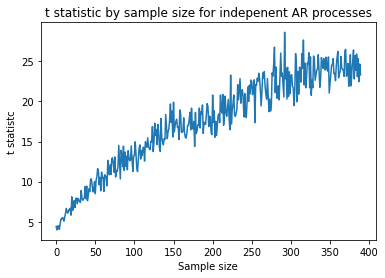

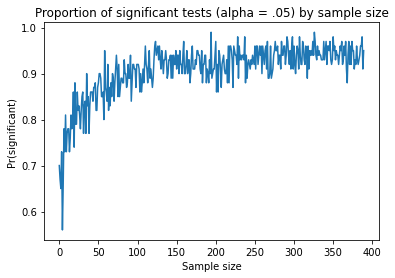

In [6]:
## Simulate autoregressive process and calculate correlations and t statistic for different sample sizes

# Set random seed for reproducibility
np.random.seed(1)

# Number of time iterations and different sample sizes
times = 100
ns = list(np.arange(50, 2000, 5))

# Create combinations of time and sample size
comb = pd.DataFrame(
    [(ix, n) for ix in range(1, times + 1) for n in ns],
    columns=['ix', 'n']
)
ncomb = len(comb)

# Initialize result array and column names
res = np.empty((ncomb, 5))
res[:] = np.nan
colnames = ['ix', 'n', 'cor', 'tstat', 'pval']

# Iterate through combinations and calculate correlations and statistics
for i in range(ncomb):
    n = comb.loc[i, 'n']
    ix = comb.loc[i, 'ix']
    sim1 = causal.simulate_ar(n, phi=1, sigma = 1)
    sim2 = causal.simulate_ar(n, phi=1, sigma = 1)
    cor, pval = pearsonr(sim1, sim2)
    tstat = cor * np.sqrt((n - 2) / (1 - cor**2))
    res[i, :] = [ix, n, cor, tstat, pval]

# Create a DataFrame from the results
tab = pd.DataFrame(res, columns=colnames)

# Group the DataFrame by 'n' and calculate summary statistics
tab_grouped = tab.groupby('n').agg(
    avg_abs_corr=('cor', lambda x: np.mean(np.abs(x))),
    avg_abs_tstat=('tstat', lambda x: np.mean(np.abs(x))),
    percent_sig=('pval', lambda x: np.mean(x < 0.05))
).reset_index()

# Round values for cleaner presentation
tab_grouped = tab_grouped.round(2)

# Print the grouped and summarized results
plt.figure()
plt.plot(tab_grouped['avg_abs_tstat'])
plt.title('t statistic by sample size for indepenent AR processes')
plt.xlabel('Sample size')
plt.ylabel('t statistc')

plt.figure()
plt.plot(tab_grouped['percent_sig'])
plt.title('Proportion of significant tests (alpha = .05) by sample size')
plt.xlabel('Sample size')
plt.ylabel('Pr(significant)')


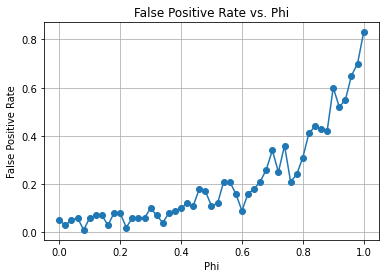

In [8]:
## Plot false positives by phi in AR process for fixed sample size

# Set random seed for reproducibility
np.random.seed(1)

# Define constants
n = 200
times = 100
phis = np.arange(0, 1.02, 0.02)

# Create combinations of time, sample size, and phi
comb = np.array(np.meshgrid(np.arange(1, times + 1), [n], phis)).T.reshape(-1, 3)
ncomb = len(comb)

# Initialize result array and column names
res = np.empty((ncomb, 6))
res[:] = np.nan
colnames = ['ix', 'n', 'phi', 'cor', 'tstat', 'pval']

for i in range(ncomb):
    ix, n, phi = comb[i]
    sim1 = causal.simulate_ar(int(n), phi=phi, sigma = 1)
    sim2 = causal.simulate_ar(int(n), phi=phi, sigma = 1)
    cor, pval = pearsonr(sim1, sim2)
    tstat = cor * np.sqrt((n - 2) / (1 - cor**2))
    res[i, :] = [ix, n, phi, cor, tstat, pval]

# Calculate false positive rates for different phi values
phi_values = np.unique(res[:, 2])
false_positive_rates = []

for phi in phi_values:
    subset = res[res[:, 2] == phi]
    false_positive_rate = np.mean(subset[:, 5] < 0.05)
    false_positive_rates.append(false_positive_rate)

# Plot false positive rates against phi values
plt.plot(phi_values, false_positive_rates, marker='o')
plt.xlabel('Phi')
plt.ylabel('False Positive Rate')
plt.title('False Positive Rate vs. Phi')
plt.grid(True)
